In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

<b> Question 1: <u>Modeling volatility Find data for historical prices for any publicly traded equity. </u></b>

To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness.

In [33]:
spy = yf.Ticker('SPY')
df = spy.history(period="5y")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-18 00:00:00-04:00,434.190002,435.179993,429.089996,430.209991,93559800,0.0,0.0,0.0
2023-10-19 00:00:00-04:00,430.950012,432.820007,425.730011,426.429993,121323000,0.0,0.0,0.0
2023-10-20 00:00:00-04:00,425.980011,426.540009,421.079987,421.190002,123845800,0.0,0.0,0.0
2023-10-23 00:00:00-04:00,419.609985,424.450012,417.799988,420.459991,91920800,0.0,0.0,0.0
2023-10-24 00:00:00-04:00,422.649994,424.179993,422.429993,424.082001,15579090,0.0,0.0,0.0


<b> 1. <u>Geometric Brownian motion </b>

$\frac{lnS(t_i)-lnS(t_{i-1})}{\sqrt{\Delta t}}= (\mu-\frac{1}{2}\sigma^2)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}}$

In [34]:
y = np.log(df.Close/df.Close.shift(1))*np.sqrt(252)

In [35]:
#historic volatility
hv = y.std()
hv

0.21465046128077023

$ s^2 = \frac{1}{N-1} (\sum_{i=1}^{N}y_i^2-N\overline{y}^2)  $

In [36]:
np.sqrt(((y**2).sum()-len(y)*y.mean()**2)/(len(y)-1))

0.21456497201006797

<b> 2. <u>Any non-constant volatility model</u></b>

a. Rolling 20d historic volatility

In [37]:
name = spy.option_chain().underlying['longName']

Text(0, 0.5, 'volatility')

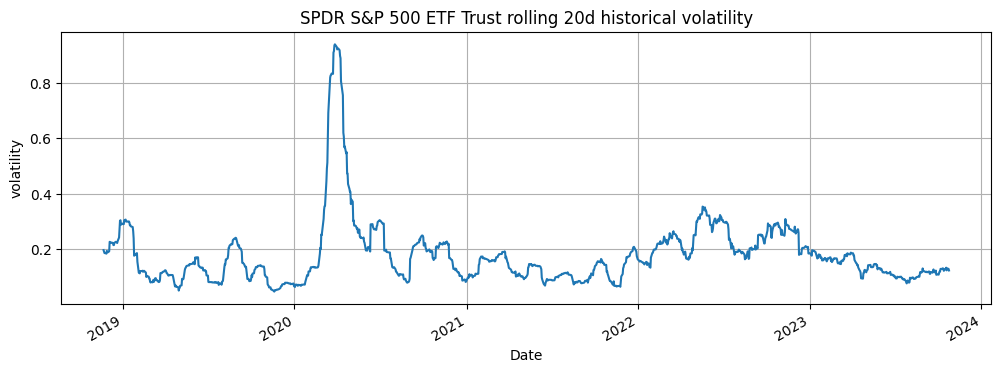

In [38]:
# rolling 20d historic volatility
ax = (y.rolling(20).std()).plot(figsize=(12,4),grid=True,title=name+' rolling 20d historical volatility')
ax.set_ylabel('volatility')

b. EWMA volatility model

In [39]:
#EWMA volatility model
vol0 = y[:21].std()
decay = 0.9
ewma_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    ewma_vol.iloc[i] = (1-decay)*y.iloc[i-1]**2 + decay*vol0**2
    vol0 =  ewma_vol.iloc[i]
ewma_vol = np.sqrt(ewma_vol)


Text(0, 0.5, 'volatility')

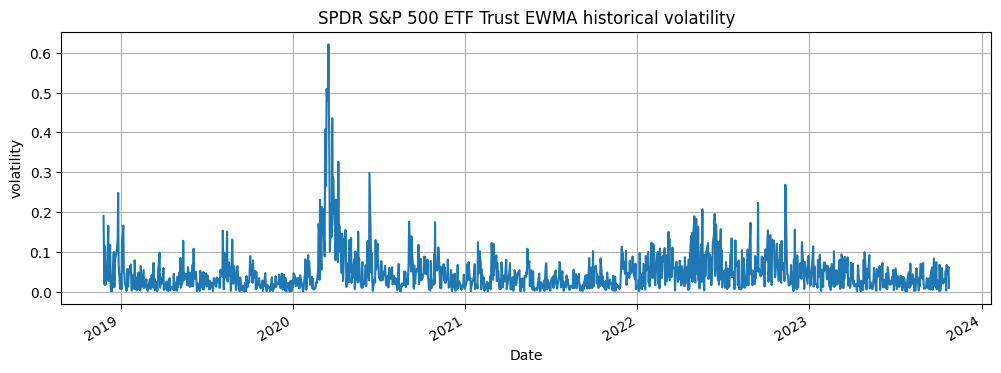

In [40]:
ax = ewma_vol.plot(figsize=(12,4),grid=True,title=name+' EWMA historical volatility')
ax.set_ylabel('volatility')

c. GARCH Model

$y_i=\frac{lnS(t_i)-lnS(t_{i-1})-(\mu-\frac{1}{2}\sigma_i^2)\Delta t}{\sqrt{\Delta t}} \quad \text{follows} \quad N(0,\sigma_i^2)$

$\sigma_{i+1}^2=\kappa\theta+(1-\kappa)[(1-\lambda)y_i^2+\lambda\sigma_i^2]$

In [41]:
import arch
from datetime import datetime

In [42]:
log_rtn = np.log(df.Close/df.Close.shift(1)).dropna()
log_rtn.index = pd.to_datetime(log_rtn.index,utc=True)

In [43]:
# Create a GARCH model and fit it to the data
model = arch.arch_model(log_rtn, vol='GARCH', p=1, q=1 , rescale=False)

split_date = log_rtn.index[-5]
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.342886617319703e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3464194216259883e+19
Iteration:      3,   Func. Count:     31,   Neg. LLF: -3933.2244866434494
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3933.2244836250284
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3


In [44]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3933.22
Distribution:                  Normal   AIC:                          -7858.45
Method:            Maximum Likelihood   BIC:                          -7837.92
                                        No. Observations:                 1252
Date:                Tue, Oct 24 2023   Df Residuals:                     1251
Time:                        22:27:50   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.5578e-04  2.011e-07   4753.186      0.000 [9.

c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

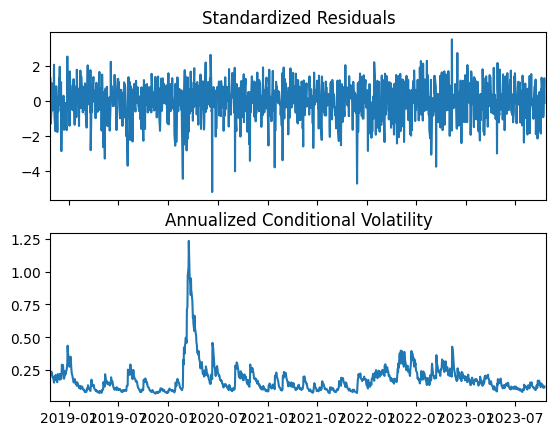

In [45]:
fig = res.plot(annualize="D")

In [46]:
res.forecast(horizon=1).variance**0.5*np.sqrt(252)

,h.1
Date,
2023-10-17 04:00:00+00:00,0.117013
2023-10-18 04:00:00+00:00,0.148358
2023-10-19 04:00:00+00:00,0.151367
2023-10-20 04:00:00+00:00,0.166541
2023-10-23 04:00:00+00:00,0.151397
2023-10-24 04:00:00+00:00,0.147406


In [47]:
kappa = 0.01
theta = 0.04
dacay = 0.9

In [48]:
#GARCH volatility model
vol0 = y[:21].std()
garch_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    garch_vol.iloc[i] = kappa*theta+(1-kappa)*((1-decay)*y.iloc[i-1]**2 + decay*vol0**2)
    vol0 =  garch_vol.iloc[i]
garch_vol = np.sqrt(garch_vol)


Text(0, 0.5, 'volatility')

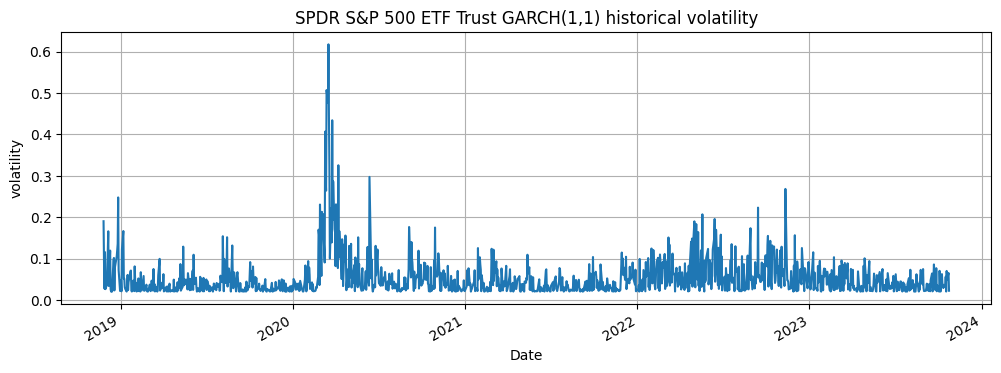

In [49]:
ax = garch_vol.plot(figsize=(12,4),grid=True,title=name+' GARCH(1,1) historical volatility')
ax.set_ylabel('volatility')

<b> 3. <u>Show volatility smile </u></b>

In [50]:
tk = yf.Ticker("SPY")
# Expiration dates
exps = tk.options
# Get options for each expiration
options = pd.DataFrame()
for e in exps:
    opt = tk.option_chain(e)
    opt.calls['optionType'] = 'Call'
    opt.puts['optionType'] = 'Put'
    opt.calls['expirationDate'] = e
    opt.puts['expirationDate'] = e
    
    options = pd.concat([options, pd.concat([opt.calls, opt.puts])])
    

In [51]:
spot = tk.history()["Close"].iloc[-1]

In [52]:
options["Moneyness"] = round(options["strike"]/spot,2)
options = options.set_index("Moneyness")

In [53]:
iv_surface = pd.DataFrame()
for t in exps:
    ivc = options[(options["expirationDate"] == t) & (options["inTheMoney"] == False)].sort_values("strike")["impliedVolatility"]
    adj_ivc = ivc.groupby("Moneyness").mean()
    adj_ivc.name = t
    iv_surface = pd.concat([iv_surface, adj_ivc], axis = 1)

In [54]:
iv_surface.columns = pd.to_datetime(iv_surface.columns)
iv_surface = iv_surface.sort_index()
iv_surface = iv_surface.interpolate(limit_area="inside")

In [55]:
thirdW5 = pd.date_range(exps[0], exps[-1], freq="WOM-3FRI")
thirdW5 = iv_surface.columns.intersection(thirdW5)

In [56]:
name = tk.option_chain().underlying['longName']

Text(0.5, 1.0, 'IV Curve of SPDR S&P 500 ETF Trust')

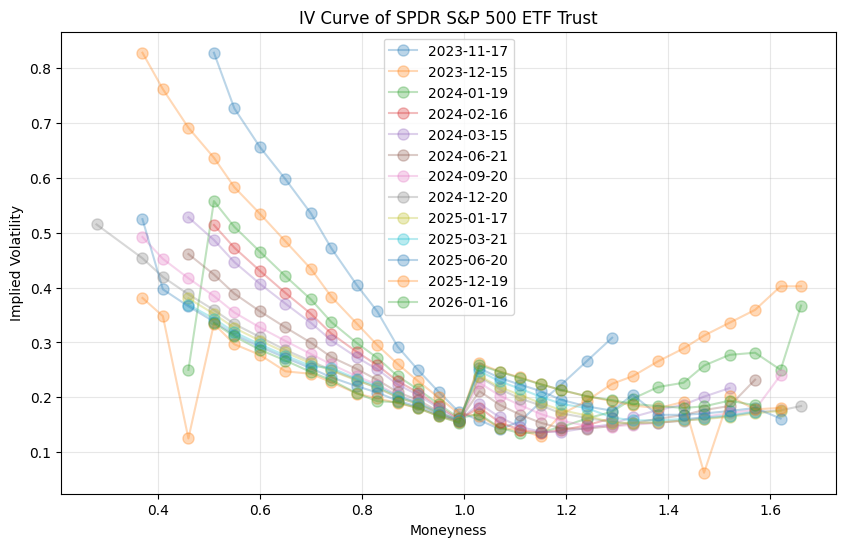

In [57]:
ax = iv_surface.loc[::4,thirdW5].plot(figsize=(10,6), style='-o', alpha = 0.3, ms=8)
ax.grid(alpha = 0.3)
ax.legend(thirdW5.strftime("%Y-%m-%d"))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Implied Volatility")
ax.set_title('IV Curve of '+name)

<b> 4. <u>Construct term structure of volatility</u></b>

Text(0.5, 1.0, 'IV Term Structure of SPDR S&P 500 ETF Trust')

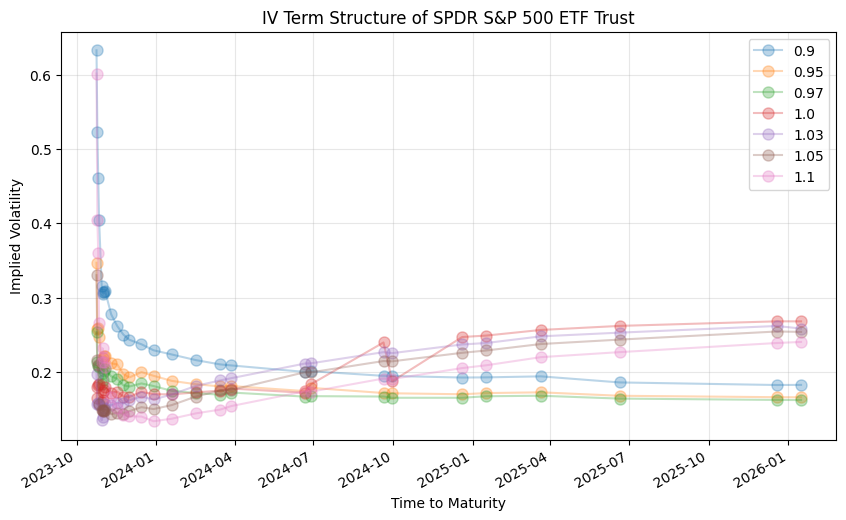

In [58]:
ax = iv_surface.transpose()[[0.9,0.95,0.97,1,1.03,1.05,1.1]].plot(figsize=(10,6), style='-o', alpha = 0.3, ms=8)
ax.grid(alpha = 0.3)
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Implied Volatility")
ax.set_title('IV Term Structure of '+name)

<b> 5. <u>Plot the volatility surface, as a function of time to maturity and moneyness.</u></b>

In [59]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [60]:
#Singapore time is ahead 1 day to the US time
time2maturity = [((i - datetime.today()).days + 1) / 365 for i in iv_surface[thirdW5].columns]

Text(0.5, 0.92, 'IV Surface of SPDR S&P 500 ETF Trust')

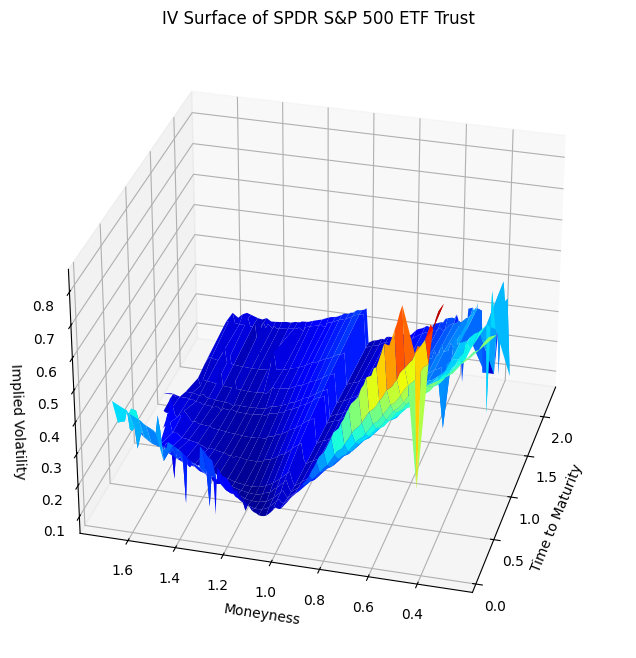

In [61]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(time2maturity, iv_surface[thirdW5].index)
ax.plot_surface(X, Y, iv_surface[thirdW5], cmap=cm.jet, linewidth=0.2)
ax.view_init(30, -165) 
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Moneyness")
ax.set_zlabel("Implied Volatility")
ax.set_title('IV Surface of '+name)

<b> Question 2: <u>Vanilla European option pricing Use the non-constant volatility model obtained in Question 1(2).</u></b>

Calculate the price of a European call option (whose today’s price can be observed in market) using  

1. Monte Carlo Use the Geometric Brownian motion obtained in Question 1(1). 

Calculate the price of the same European call option using 

2. Numerical PDE
3. Binomial Model 
4. Black-Scholes formula

For each part of 1 to 3, show how accuracy can be improved by increasing computational time. Lastly,  

5. Compare the four calculated prices with the “true price” observed in market. 

Comment on these  methods based on their efficiency and accuracy. Explain any source of error and make 
suggestions on possible ways to reduce the error.

In [62]:
hv

0.21465046128077023